# Can we use local field potentials to predict trial stops?

In [1]:
import numpy as np
import pandas as pd
import physutils
import dbio
import os
import pywt
from __future__ import division
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
np.random.seed(12345)

## Load Data

In [2]:
# which patient, dataset to plot
dtup = 17, 2

In [3]:
# load data
dbname = os.path.expanduser('data/bart.hdf5')
lfpraw = dbio.fetch_all_such_LFP(dbname, *dtup)

## Preprocess Data

In [4]:
lfp = lfpraw.demean()

In [5]:
# decimate to 40 Hz, censor, and z-score each channel
lfp = lfp.decimate(5).censor().zscore()

In [6]:
# get events
evt = dbio.fetch(dbname, 'events', *dtup)
stops = evt['banked'].dropna()
pops = evt['popped'].dropna()
starts = evt['start inflating']
if 'is_control' in evt.columns:
    stops_free = evt.query('is_control == False')['banked'].dropna()
    stops_control = evt.query('is_control == True')['banked'].dropna()
    stops_rewarded = evt.query('trial_type != 4')['banked'].dropna()
    stops_unrewarded = evt.query('trial_type == 4')['banked'].dropna()
else:
    stops_free = stops
    stops_rewarded = stops

## Get True Positives

In [7]:
truepos = pd.DataFrame(stops_free.values, columns=['time'])
truepos['outcome'] = 1

## Get True Negatives

We will choose as true negatives an equal number of random times that are not within a fixed interval of any true positives.

In [8]:
def within_range(test_value, anchor_list, radius_tuple):
    # return true when test_value is not within a radius tuple
    # of any value in anchor_list 
    # NOTE: both elements of radius_tuple must be positive!

    dist = test_value - np.array(anchor_list)
    within_range = np.logical_and(dist > -radius_tuple[0],
        dist < radius_tuple[1]) 
    return np.any(within_range)

In [9]:
Tpre = 2  # time before stop to exclude
Tpost = 1.5  # time after stop to exclude
dt = (1. / lfp.meta['sr']).round(3) 

In [10]:
maxT = lfp.index[-1]
Nrand = truepos.shape[0]  # number to generate: same as number of true positives
Ncand = 2000  # number to filter down to Nrand
candidates = np.random.rand(Ncand) * (maxT - Tpre) + Tpre
candidates = np.around(candidates / dt) * dt  # round to nearest dt
candidates = np.unique(candidates)
np.random.shuffle(candidates)
rand_times = filter(lambda x: ~within_range(x, truepos['time'], 
                                            (Tpre, Tpost)), candidates)[:Nrand]
trueneg = pd.DataFrame(rand_times, columns=['time'])
trueneg['outcome'] = 0

## Concatenate true and false positives together to form training labels:

In [11]:
allevt = pd.concat([truepos, trueneg])
allevt = allevt.set_index('time')

## Grab signal around each event, decompose in wavelet basis

In [12]:
chunksize = 2   # length of sample before event (in s)
chunks = lfp.evtsplit(allevt.index, -chunksize, 0)

In [13]:
# make function to do wavelet decomposition
wname = 'db1'
def wav_decomp(x):
    cA, cD = pywt.dwt(x, wname)
    return np.concatenate([cA, cD])

def df_wav_decomp(df):
    pieces = []
    for col in df:
        pieces.append(pd.DataFrame(wav_decomp(df[col]), columns=[col]))
    return pd.concat(pieces, axis=1)
    
def df_wav_recons(df):
    pieces = []
    for col in df:
        x = df[col]
        mid = x.size // 2
        cA = x[:mid]
        cD = x[mid:]
        pieces.append(pd.DataFrame(pywt.idwt(cA, cD, wname), columns=[col]))
    return pd.concat(pieces, axis=1)

In [14]:
# convert data to wavelet basis
wavdat = chunks.groupby(level=0).apply(df_wav_decomp)

In [15]:
# unstack index to get one row per trial
wavfeatures = wavdat.unstack()
trainset = pd.concat([allevt.reset_index(drop=True), wavfeatures], axis=1)
trainset = trainset.dropna()

## Run sparse regression in R

In [16]:
%load_ext rpy2.ipython

In [17]:
%%R
set.seed(77654)
suppressMessages(library(glmnet))
source('glm_helpers.R')

In [18]:
%Rpush trainset
%R fitobj <- run_glm(data.matrix(trainset), measure='auc');

In [19]:
%%R -o auc
source('helpers.R')

# get performance
glmobj <- fitobj$glmobj
min.ind <- which(glmobj$lambda == glmobj$lambda.min)
auc <- glmobj$cvm[min.ind]

In [20]:
%%R -o coef_grid
coef_grid <- fitobj$beta

In [21]:
coef_grid

array([ 0.        ,  0.        ,  0.        , ...,  0.        ,
        0.28696987,  0.        ])

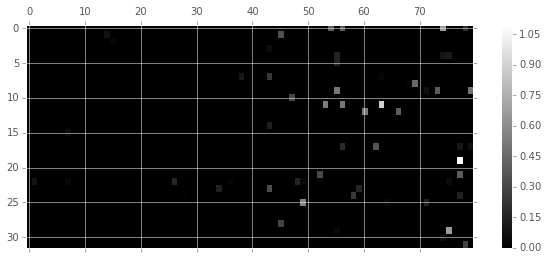

In [22]:
nchan = lfp.shape[1]
cg = pd.DataFrame(np.reshape(coef_grid, (nchan, -1)).T, columns=lfp.columns)
plt.matshow(np.abs(cg.T), aspect='auto', cmap='gray');
plt.colorbar();

In [23]:
# prepare to reconstruct
def wav_reconstruct(x):
    mid = x.size // 2
    cA = x[:mid]
    cD = x[mid:]
    return pywt.idwt(cA, cD, wname)

In [24]:
filts = df_wav_recons(cg)

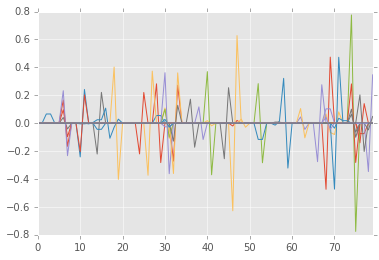

In [25]:
filts.plot(legend=False);